In [1]:
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
path="E:\Python_Training\Kaggle\Pollen_bee_classification\honey-bee-pollen\PollenDataset\images"

imlist= glob.glob(os.path.join(path, '*.jpg'))

# Data import

In [5]:
def dataset(file_list,size=(300,180),flattened=False):
	data = []
	for i, file in enumerate(file_list):
		image = io.imread(file)
		image = transform.resize(image, size, mode='constant')
		if flattened:
			image = image.flatten()

		data.append(image)

	labels = [1 if f.split("\\")[-1][0] == 'P' else 0 for f in file_list]

	return np.array(data), np.array(labels)

In [6]:
X,y=dataset(imlist)

## Normalizing data

In [7]:
norm=X.mean()

In [8]:
X=X-norm

In [9]:
X.max()

0.7000380205483295

In [10]:
X.min()

-0.29996197945167047

In [11]:
X.mean()

-1.1430535906700293e-15

In [12]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

# Data exploration

In [13]:
print('The length of X: ',len(X))  # data
print('The shape of X: ',X.shape)  # target
print('The shape of Y', y.shape)


The length of X:  714
The shape of X:  (714, 300, 180, 3)
The shape of Y (714,)


In [14]:
img=imlist[0]

In [19]:
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img+norm)
  plt.show()

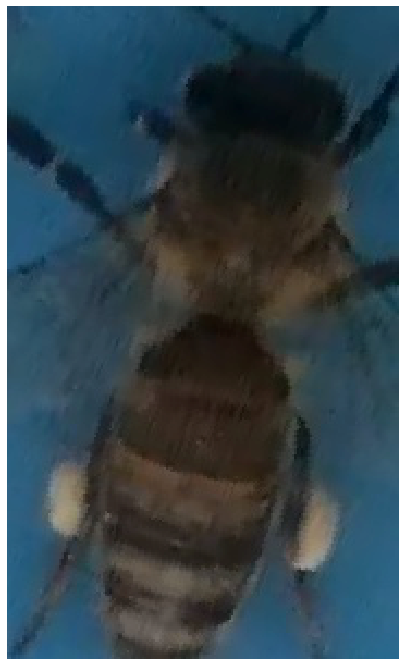

In [20]:
show(X[5])

# Dimensionality reduction

In [99]:
# Dimensionality reduction to avaid OOM error (running on 3GB GPU)
max_pool = keras.layers.MaxPool2D(pool_size=2)

def batch_dim_red(X):
    for i in range(1,int(X.shape[0]/100)+2):
        Xt=X[(i-1)*100:i*100]
        Xt=max_pool(Xt)
        if i==1:
            X_red=Xt
        else:
            X_red=tf.concat([ X_red, Xt], 0)
    return np.asarray(X_red)

In [100]:
X_red=batch_dim_red(X)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [101]:
y.sum()/y.shape[0] #the dataset seems to be balance with both instances

0.5168067226890757

In [104]:
n_train=int(n*0.6)
n_val=int(0.2*n)

In [105]:
X_train, X_val, X_test=X_red[:n_train],X_red[n_train:(1-n_val)], X_red[(1-n_val):]
y_train, y_val, y_test=y[:n_train],y[n_train:(1-n_val)], y[(1-n_val):]

In [106]:
X_train.shape

(428, 150, 90, 3)

In [107]:
X_val.shape

(145, 150, 90, 3)

In [109]:
X_test.shape

(141, 150, 90, 3)

# Initial model

In [110]:

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=(3,3), input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=198, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [111]:

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 150, 90, 64)       1792      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 75, 45, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 75, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 37, 22, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 37, 22, 128)       73856     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 37, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 18, 11, 128)      

In [112]:
model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], batch_size=15)


Train on 428 samples, validate on 145 samples
Epoch 1/50
428/428 [==============================] - 3s 7ms/sample - loss: 0.8340 - accuracy: 0.4953 - val_loss: 0.6950 - val_accuracy: 0.4483
Epoch 2/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.7034 - accuracy: 0.5491 - val_loss: 0.6893 - val_accuracy: 0.5517
Epoch 3/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.7006 - accuracy: 0.5304 - val_loss: 0.6794 - val_accuracy: 0.5517
Epoch 4/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.7001 - accuracy: 0.5467 - val_loss: 0.6889 - val_accuracy: 0.5517
Epoch 5/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.6575 - accuracy: 0.6005 - val_loss: 0.6246 - val_accuracy: 0.7862
Epoch 6/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.4439 - accuracy: 0.8551 - val_loss: 0.4242 - val_accuracy: 0.8207
Epoch 7/50
428/428 [==============================] - 1s 3ms/sample - loss: 0.1967 - accur

In [113]:
score = model.evaluate(X_test, y_test)

141/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Analyzing misclasified cases

In [122]:
y_pred = model.predict(X_test)
y_pred=np.around(y_pred)
y_base=y_test.reshape((len(y_test),1))
match_arr=(y_base==y_pred)
ix_mc=np.where(np.isin(match_arr,False))[0]

In [124]:
y_pred.sum()

63.0

In [125]:
y_test.sum()

66

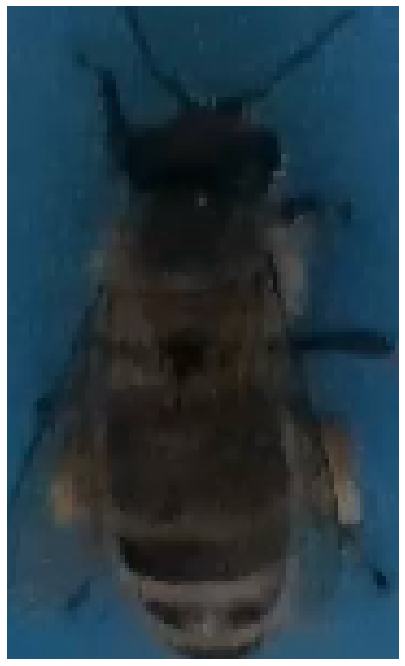

1


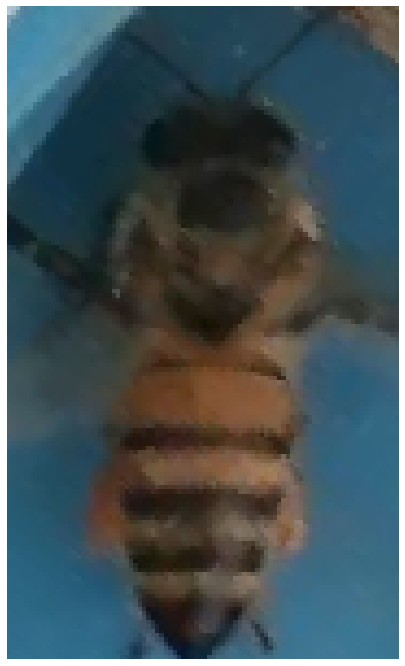

1


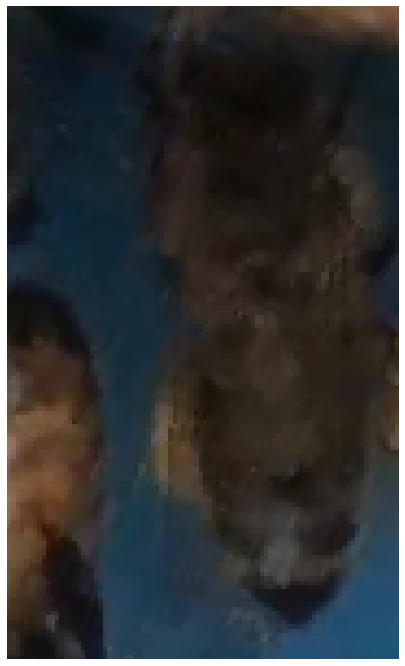

0


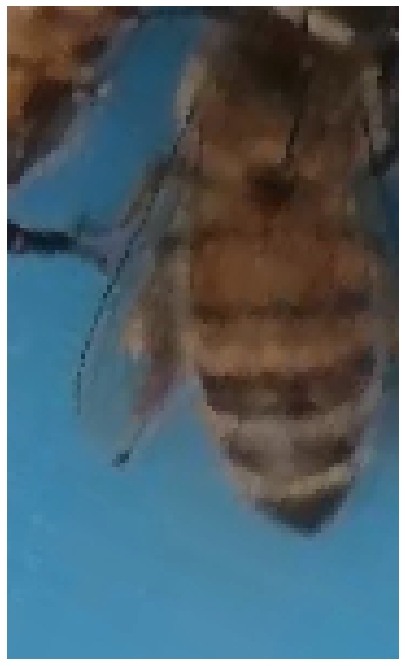

1


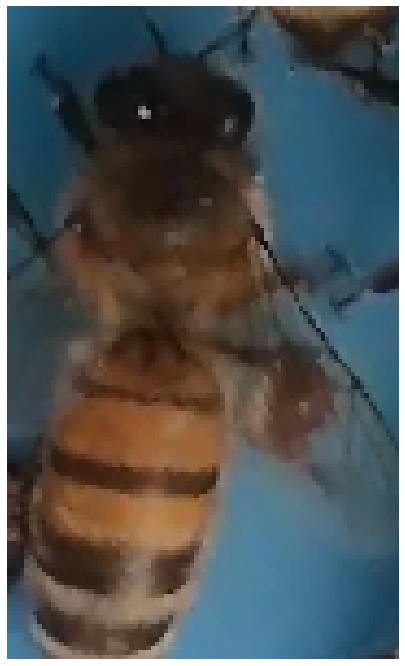

1


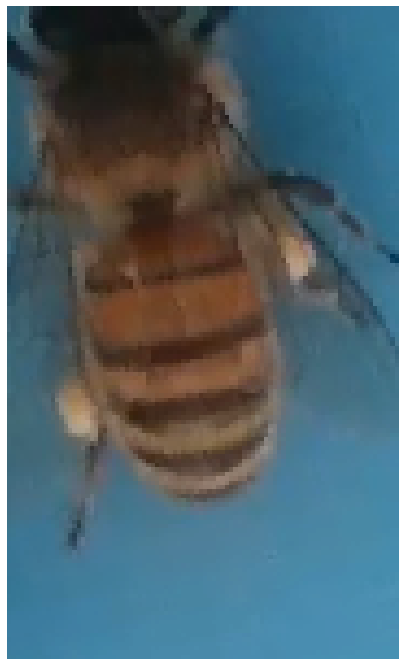

1


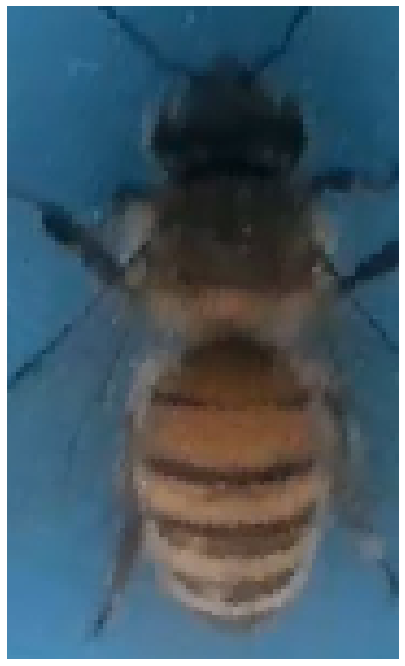

0


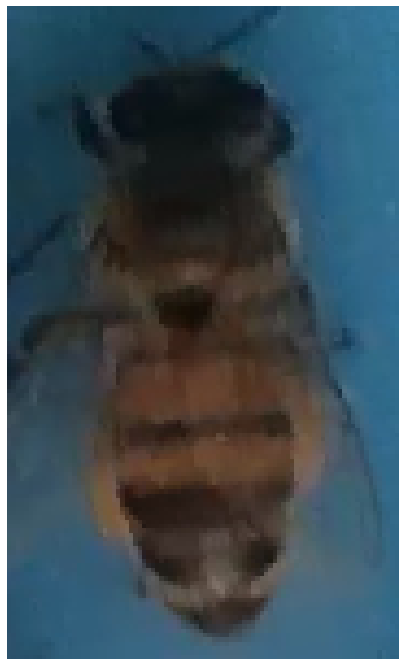

0


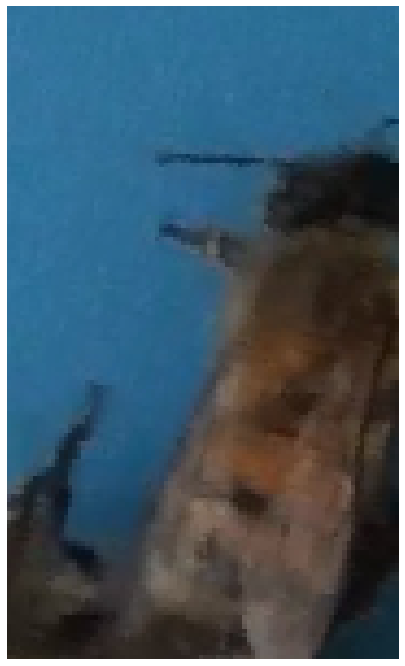

0


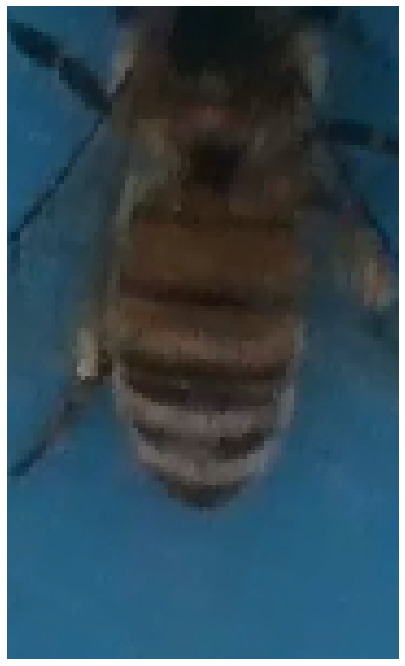

1


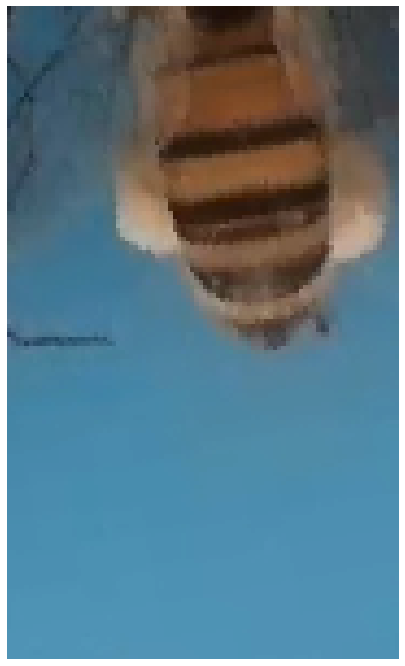

1


In [129]:
for i in ix_mc:
    show(X_test[i])
    print(y_test[i])

The CNN seems to have issue with images where part of the bee is cut. Let's augment the training set with shifted images to try and tackle that. 

# Data Augmentation

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
X_red_train, X_red_test, y_train, y_test=train_test_split(X_red, y, test_size=0.2, random_state=42)

In [132]:
X_red_train.shape

(571, 150, 90, 3)

## Flipping left to right

In [133]:
img=X_red[:3]

In [134]:
type(img)

numpy.ndarray

In [135]:
img_flip=tf.image.random_flip_left_right(img)

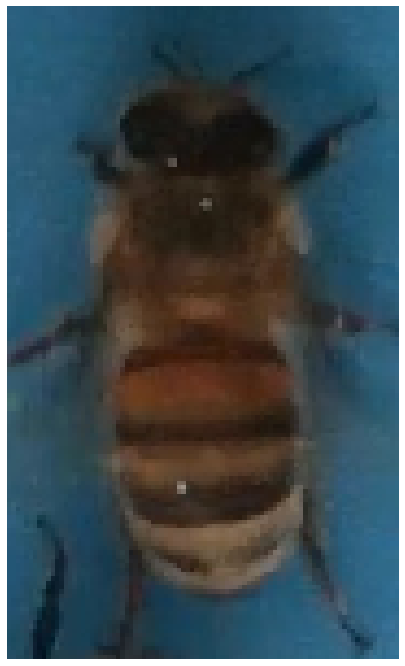

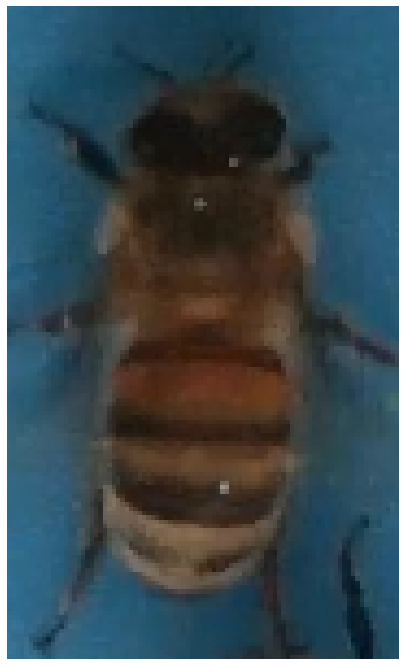

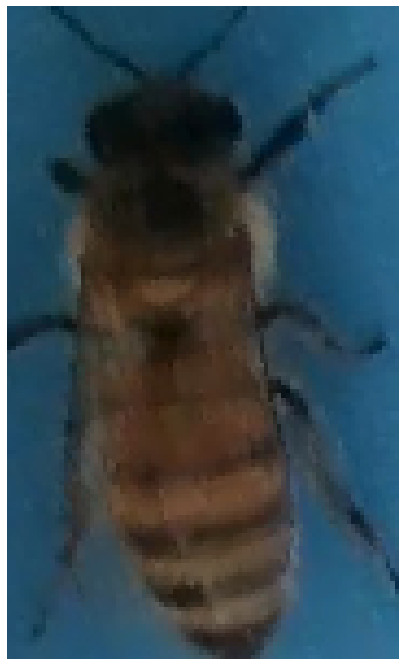

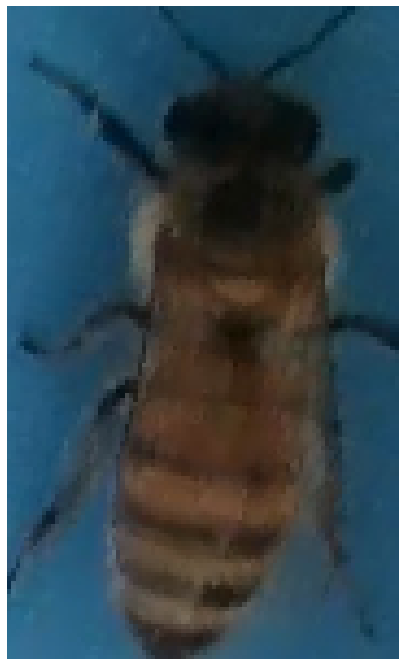

In [136]:
for i in range(0,2):
    img_flip=tf.image.flip_left_right(img[i])
    show(img_flip)
    show(img[i])

## Flipping up and down

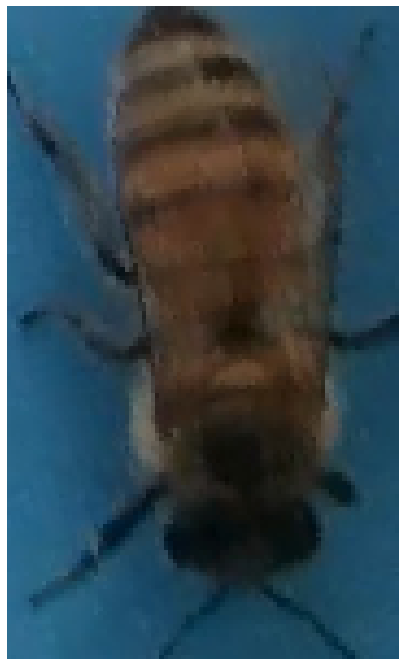

In [137]:
img_flip2=tf.image.flip_up_down(img[1])
show(img_flip2)

## Random shift

In [147]:
img_shift=tf.keras.preprocessing.image.random_shift(
    img[0],
    0.2,
    0.2,
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='nearest',
    cval=0
    
)

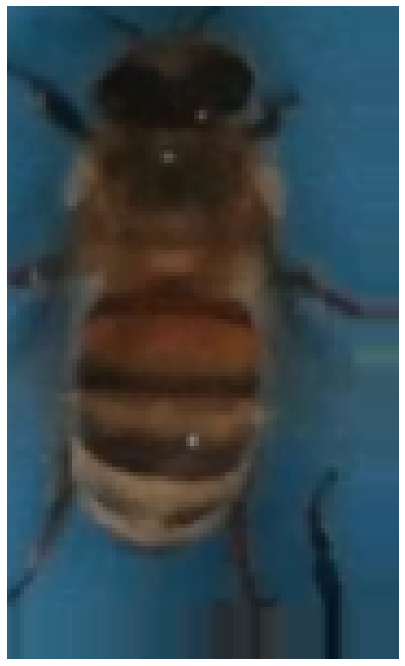

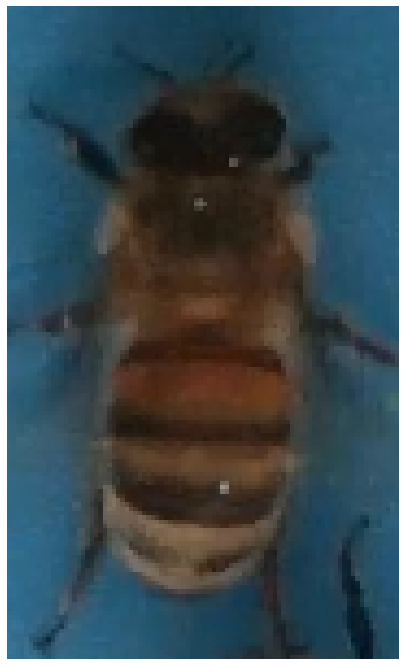

In [148]:
show(img_shift)
show(img[0])

In [150]:
def augment_shift(X,y):
    y_aug=[]
    for i in range(0,int(X.shape[0])):
        X_shift=tf.keras.preprocessing.image.random_shift(
            X[i],
            0.2,
            0.2,
            row_axis=0,
            col_axis=1,
            channel_axis=2,
            fill_mode='constant',
            cval=0

        )
        X_shift=X_shift.reshape((1,150, 90, 3))
        y_aug.append(y[i])
        
        if i==0:
            X_aug=X_shift
        else:
            X_aug=tf.concat([X_aug, X_shift], 0)
            
    return [np.asarray(X_aug), np.asarray(y_aug)]

In [151]:
X_shift,y_shift=augment_shift(X_red_train, y_train)
X_shift.shape

(571, 150, 90, 3)

In [152]:
y_shift.shape

(571,)

In [162]:
y_train.shape

(571,)

In [163]:
X_shift.shape

(571, 150, 90, 3)

In [169]:
X_ag_train=np.asarray(tf.concat([X_red_train, X_shift], 0))

In [170]:
X_ag_train.shape

(1142, 150, 90, 3)

In [171]:
y_ag_train=np.asarray(tf.concat([y_train, y_shift], 0))

In [172]:
y_ag_train.shape

(1142,)

In [174]:
X_train, X_valid, y_train, y_valid=train_test_split(X_ag_train, y_ag_train, test_size=0.25, random_state=42)

In [175]:
X_train.shape

(856, 150, 90, 3)

In [176]:
y_train.shape

(856,)

# Training model on enriched data

In [244]:

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu', padding="SAME")

model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=(3,3), input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=198, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [245]:
model2.compile(loss='binary_crossentropy', optimizer="nadam", metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=100, validation_data=[X_val, y_val], batch_size=15)

Train on 856 samples, validate on 145 samples
Epoch 1/100
856/856 [==============================] - 4s 5ms/sample - loss: 0.7395 - accuracy: 0.5549 - val_loss: 0.6872 - val_accuracy: 0.6000
Epoch 2/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.7274 - accuracy: 0.6086 - val_loss: 0.6919 - val_accuracy: 0.5517
Epoch 3/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.6902 - accuracy: 0.5409 - val_loss: 0.6908 - val_accuracy: 0.5517
Epoch 4/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.7628 - accuracy: 0.5421 - val_loss: 0.6914 - val_accuracy: 0.5517
Epoch 5/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.7243 - accuracy: 0.5502 - val_loss: 0.6723 - val_accuracy: 0.6414
Epoch 6/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.6703 - accuracy: 0.6238 - val_loss: 0.6841 - val_accuracy: 0.5586
Epoch 7/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.7020 

856/856 [==============================] - 2s 3ms/sample - loss: 0.0196 - accuracy: 0.9907 - val_loss: 0.0797 - val_accuracy: 0.9724
Epoch 57/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0651 - val_accuracy: 0.9793
Epoch 58/100
856/856 [==============================] - 2s 3ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9793
Epoch 59/100
856/856 [==============================] - 2s 3ms/sample - loss: 3.0749e-04 - accuracy: 1.0000 - val_loss: 0.1580 - val_accuracy: 0.9793
Epoch 60/100
856/856 [==============================] - 2s 3ms/sample - loss: 8.7546e-04 - accuracy: 1.0000 - val_loss: 0.1713 - val_accuracy: 0.9793
Epoch 61/100
856/856 [==============================] - 3s 3ms/sample - loss: 2.0599e-04 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9862
Epoch 62/100
856/856 [==============================] - 3s 3ms/sample - loss: 1.9308e-04 - accuracy: 1.0000 - val_loss: 0.145

# Analyze final model results

In [246]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points

In [247]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

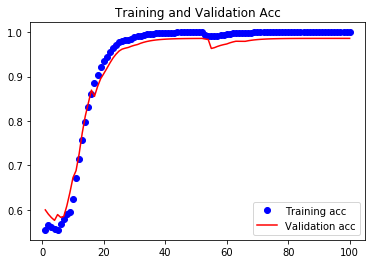

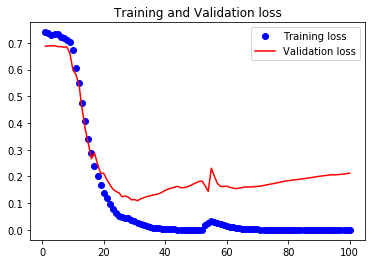

In [248]:
epochs = range(1, len(acc)+1)
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'r-', label='Validation acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

Seems to start overfitting around epoch 50

In [251]:

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu', padding="SAME")

model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=(3,3), input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=198, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [252]:
model2.compile(loss='binary_crossentropy', optimizer="nadam", metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], batch_size=15)

Train on 856 samples, validate on 145 samples
Epoch 1/50
856/856 [==============================] - 4s 5ms/sample - loss: 0.7056 - accuracy: 0.5397 - val_loss: 0.6730 - val_accuracy: 0.7172
Epoch 2/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.6498 - accuracy: 0.6659 - val_loss: 0.7376 - val_accuracy: 0.4483
Epoch 3/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.6855 - accuracy: 0.6332 - val_loss: 0.6349 - val_accuracy: 0.6138
Epoch 4/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.5739 - accuracy: 0.7056 - val_loss: 0.9836 - val_accuracy: 0.7310
Epoch 5/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.3180 - accuracy: 0.8657 - val_loss: 0.3038 - val_accuracy: 0.8759
Epoch 6/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.2111 - accuracy: 0.9147 - val_loss: 0.4675 - val_accuracy: 0.7310
Epoch 7/50
856/856 [==============================] - 2s 3ms/sample - loss: 0.1945 - accur

In [254]:
score = model2.evaluate(X_red_test, y_test)

143/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Much better after augmentation!

In [259]:
y_pred = model.predict(X_test)
y_pred=np.around(y_pred)
y_base=y_test.reshape((len(y_test),1))

In [263]:
y_pred.shape

(141, 1)

In [264]:
y_base.shape

(143, 1)

In [260]:
match_arr=(y_base==y_pred)
ix_mc=np.where(np.isin(match_arr,False))[0]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [261]:
ix_mc

array([0], dtype=int64)